In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(2025)            # seed for reproducibility
from make_data import make_data_multinomial_change_point


In [2]:
data = make_data_multinomial_change_point()
data

array([[ 22.,  66., 107.],
       [ 42.,  77., 117.],
       [ 18.,  46.,  64.],
       ...,
       [ 48.,  61.,  71.],
       [ 32.,  38.,  49.],
       [ 63.,  61., 107.]])

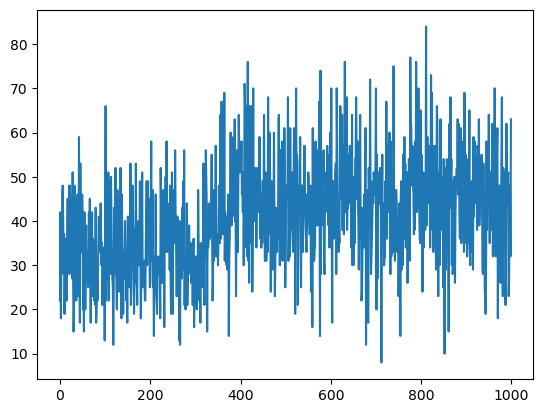

In [3]:
plt.plot(data[:,0])

In [4]:
def lik(data, tau, p_l, p_r):
    """
    Calculates the log likelihood of the observations.
    """
    return (data[:tau]*np.log(p_l)).sum() + (data[tau:]*np.log(p_r)).sum()

def sample_tau_constant_prior(data, lik, theta_l, theta_r, trim=5):
    """
    Samples tau conditioned on the data, theta_l and theta_r.
    It exclueds the first and last values for consitent estimation, adjustable with 'trim'
    """
    l = np.array([ lik(data, tau, theta_l, theta_r) for tau in range(len(data))])
    l -= l.max()    #shift values to avoid presicion issues.
    l = np.exp(l)
    l[:trim] = 0
    l[-trim:] = 0
    l/=l.sum()      #normalize to make it a proper distribution.
    taus = np.arange(0,len(data), 1)
    return np.random.choice(taus,p=l)

def make_chain(data, alpha, length, tau0):
    dim = 2*len(alpha)+1 #dimension is: #left parameters + #rigth parameres + #tau
    res = np.zeros(shape=(length, dim)) # storage array
    res[0] = np.concatenate(([tau0], alpha, alpha))
    tau = tau0
    for i in range(1,length):
        p_l = np.random.dirichlet(data[:tau].sum(axis=0) + alpha)
        p_r = np.random.dirichlet(data[tau:].sum(axis=0) + alpha)
        tau = sample_tau_constant_prior(data, lik, p_l, p_r)
        res[i] = np.concatenate(([tau], p_l, p_r))

    return res
        


In [5]:
alpha = np.array([1, 1, 1.0])
alpha/=alpha.sum()
chain = make_chain(data, alpha, 100, 10)

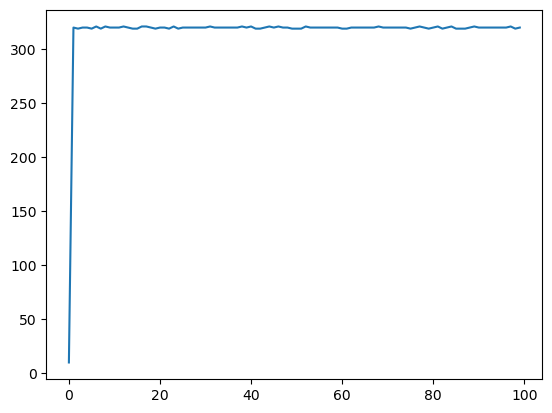

In [6]:
plt.plot(chain[:,0])